# Tap30 Challenge

Importing Libraries, we will be needed :

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from numpy import array
import os
%matplotlib inline

## Reading

In [3]:
desc_data = pd.read_csv('data.txt',header=None,nrows=2)
t_period = int(desc_data.iloc[0][0])
width,height = list(map(int, desc_data.iloc[1][0].split(' ')))
pre_data = pd.read_csv('data.txt',header=None,skiprows=[0,1],sep=' ')
time_series = np.array(pre_data).reshape(-1,height * width)

## Visualizing

In [6]:
pre_data.head(height)

0  1  2   3   4   5   6   7
0  0  0  5  -1  -1  -1  -1  33
1 -1 -1 -1  19  14   8  -1  -1
2 -1 -1  3  17  14  11  -1   3
3  0  5  0   8  -1  19  -1  -1
4  0  8 -1  -1  27  17   0  -1
5  0  0  0   3  11   3   3   3
6  0  0  0  -1   0  14  11  -1
7 -1 -1  0   0   0   0   5  -1

In [7]:
pre_data[height:].head(height)

0  1  2   3  4  5  6  7
8   0  0 -1   5  3  3  8 -1
9   0  0  0   3  3 -1  8  3
10 -1  0 -1   0  8 -1  5 -1
11 -1  0 -1  -1  0 -1  3 -1
12  0  0  5  51  0  5  0 -1
13  0  0  0   0  8  3 -1 -1
14 -1 -1  0  -1  0 -1 -1  0
15  0  0  0  -1  0 -1 -1 -1

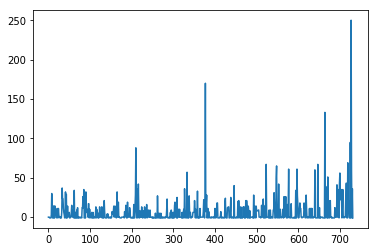

In [10]:
plt.plot(list(range(time_series.shape[0])), time_series[:,0])

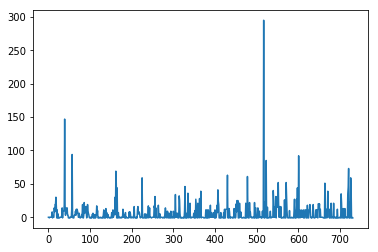

In [11]:
plt.plot(list(range(time_series.shape[0])), time_series[:,1])

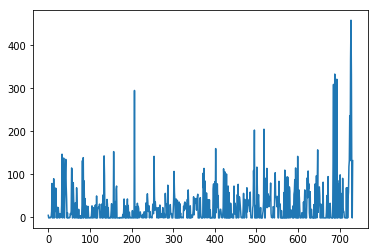

In [12]:
plt.plot(list(range(time_series.shape[0])), time_series[:,2])

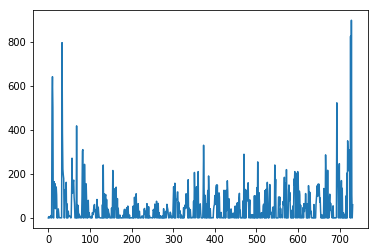

In [13]:
plt.plot(list(range(time_series.shape[0])), time_series[:,3])

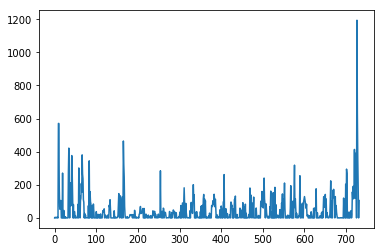

In [14]:
plt.plot(list(range(time_series.shape[0])), time_series[:,4])

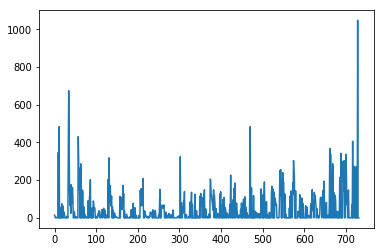

In [15]:
plt.plot(list(range(time_series.shape[0])), time_series[:,20])

In [30]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)
def create_dataset_back(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[(i+look_back):i:-1]
		dataX.append(a)
		dataY.append(dataset[i])
	return np.array(dataX), np.array(dataY)

def train_model_architecture_1(x_data,y_data,input_shape,lstm_unit,output_shape,batch_size = 12, epochs=800) :
    m = Sequential()
    m.add(Masking(mask_value=-1, input_shape=input_shape))
    m.add(LSTM(lstm_unit))
    m.add(Dense(output_shape))
    m.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    x = x_data
    y = y_data
    m.fit(x, y, epochs=epochs, batch_size=batch_size)
    return m

def train_model_architecture_2(x_data,y_data,input_shape,lstm_unit,output_shape,batch_size = 12, epochs=800) :
    m = Sequential()
#     m.add(Masking(mask_value=-1, input_shape=input_shape))
#     m.add(LSTM(lstm_unit))
#     m.add(LSTM(lstm_unit))
    m.add(TimeDistributed(Dense(output_shape,input_shape=input_shape)))
    m.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    x = x_data
    y = y_data
    m.fit(x, y, epochs=epochs, batch_size=batch_size)
    return m

def preprocessing(time_series,look_back=20,pp_type = 'forward_prediction') :
    dataset = time_series[:]
#     dataset[dataset==-1] = None
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    if pp_type == 'forward_prediction' :
        x_data , y_data = create_dataset(array(dataset),look_back)
    else :
        x_data , y_data = create_dataset_back(array(dataset),look_back)
    return x_data, y_data , scaler

def show_result(x_data,y_data,model,scaler,i = 0) :
    x = x_data[:]
    y = y_data[:]
    yhat = model.predict(x)
    yhat = scaler.inverse_transform(yhat)
    y = scaler.inverse_transform(y)
    print(y[i])
    print(yhat[i])
    plt.plot(range(y[:,i].shape[0]),y[:,i],range(y[:,i].shape[0]),yhat[:,i])
    
def show_result_2(x_data,y_data,model,scaler,i = 0) :
    x = x_data[:]
    y = y_data[:]
    yhat = model.predict(x)
    yhat = scaler.inverse_transform(yhat)
    y = scaler.inverse_transform(y)
    print(y[i])
    print(yhat[i])
    plt.plot(range(y.shape[0]),y,range(y.shape[0]),yhat)

def to_submit_file(real,predicted,height=8,width=8) :
#     submit_data = [[],[]]
#     submit_data.append('id,demand')
    real = np.array(real).reshape(-1,height,width)
    predicted = np.array(predicted).reshape(-1,height,width)
    with open('submit_file.csv','w') as submit_file :   
        submit_file.write('id,demand\n')
        for t in range(real.shape[0]) :
            for i in range(real.shape[1]) :
                for j in range(real.shape[1]) :
                    if real[t,i,j] == -1 :
                        submit_file.write(str(t) + ":" + str(i) + ":" + str(j) + "," + str(predicted[t,i,j]) + "\n")
#                         submit_data[0].append(str(t) + ":" + str(i) + ":" + str(j))
#                         submit_data[1].append(predicted[t,i,j])
#     submit_data = pd.DataFrame(np.array(submit_data))
#     submit_data.to_csv('submit_file.csv',header=('id','demand'),index=None)
# def show_result_m_n(x_data,y_data,scaler,i = 0) :
#     x = x_data[:]
#     y = y_data[:]
#     yhat = back_model.predict(x)
#     yhat = scaler.inverse_transform(yhat)
#     y = scaler.inverse_transform(y)
#     plt.figure()
#     for j in range(int(len(models)/4)):
#         plt.subplot(4, 4, i + 1)
#         plt.plot(range(y[:,j].shape[0]),y[:,j],range(y[:,j].shape[0]),yhat[:,j])
#         plt.title(str(i), y=0.5, loc='right')

In [42]:
X_back = []
Y_back = []
back_scalers = []
back_models = []
for i in range(height*width) :
    x_back, y_back, scaler_back = preprocessing(time_series[:,i].reshape(-1,1),20,'back_prediction')
    back_model = train_model_architecture_1(x_back,y_back,(20,1),40,1,6,300)
    X_back.append(X_back)
    Y_back.append(Y_back)
    back_scalers.append(scaler_back)
    back_models.append(back_model)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/300
712/712 [==============================] - 5s 7ms/step - loss: 0.0030
Epoch 2/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 3/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 4/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 5/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 6/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 7/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 8/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 9/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0030
Epoch 10/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 11/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 12/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 13/300


KeyboardInterrupt: 

In [35]:
x_back, y_back, scaler_back = preprocessing(time_series[:,0].reshape(-1,1),20,'back_prediction')
# time_series[:,0].shape

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
back_model = train_model_architecture_1(x_back[:,:,0].reshape(-1,20,1),y_back[:,0].reshape(-1,1),(20,1),40,1,6,300)

Epoch 1/300
712/712 [==============================] - 5s 8ms/step - loss: 0.0031
Epoch 2/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 3/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 4/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 5/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 6/300
712/712 [==============================] - 4s 5ms/step - loss: 0.0029
Epoch 7/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0030
Epoch 8/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0030
Epoch 9/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0029
Epoch 10/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0029
Epoch 11/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0029
Epoch 12/300
712/712 [==============================] - 4s 6ms/step - loss: 0.0029
Epoch 13/300


712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch 197/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch 198/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch 199/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch 200/300
712/712 [==============================] - 5s 8ms/step - loss: 0.0026
Epoch 201/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0026
Epoch 202/300
712/712 [==============================] - 7s 10ms/step - loss: 0.0026
Epoch 203/300
712/712 [==============================] - 5s 7ms/step - loss: 0.0026
Epoch 204/300
712/712 [==============================] - 5s 7ms/step - loss: 0.0026
Epoch 205/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0026
Epoch 206/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch 207/300
712/712 [==============================] - 6s 8ms/step - loss: 0.0027
Epoch

In [38]:
show_result(x_back[:,:,0].reshape(-1,20,1),y_back[:,0].reshape(-1,1),back_model,scaler_back,0)

[0.]
[2.672023]


In [24]:
x_forward, y_forward, scaler_forward = preprocessing(time_series,20,'forward_prediction')
forward_model = train_model_architecture_1(x_forward,y_forward,(20,64),200,64)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\deeplearning\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/800
712/712 [==============================] - 3s 4ms/step - loss: 0.0061
Epoch 2/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 3/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0051
Epoch 4/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 5/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0047
Epoch 6/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 7/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 8/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 9/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 10/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 11/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0040
Epoch 12/800
712/712 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 13/800


712/712 [==============================] - 2s 2ms/step - loss: 5.5254e-04
Epoch 194/800
712/712 [==============================] - 2s 3ms/step - loss: 5.2475e-04
Epoch 195/800
712/712 [==============================] - 2s 3ms/step - loss: 4.9050e-04
Epoch 196/800
712/712 [==============================] - 2s 3ms/step - loss: 5.0196e-04
Epoch 197/800
712/712 [==============================] - 2s 3ms/step - loss: 4.9426e-04
Epoch 198/800
712/712 [==============================] - 2s 3ms/step - loss: 5.0345e-04
Epoch 199/800
712/712 [==============================] - 2s 3ms/step - loss: 4.9299e-04
Epoch 200/800
712/712 [==============================] - 2s 3ms/step - loss: 4.9882e-04
Epoch 201/800
712/712 [==============================] - 2s 3ms/step - loss: 5.2506e-04
Epoch 202/800
712/712 [==============================] - 2s 3ms/step - loss: 4.7836e-04
Epoch 203/800
712/712 [==============================] - 2s 3ms/step - loss: 4.7280e-04
Epoch 204/800
712/712 [=======================

712/712 [==============================] - 2s 3ms/step - loss: 1.4419e-04
Epoch 379/800
712/712 [==============================] - 2s 2ms/step - loss: 1.5393e-04
Epoch 380/800
712/712 [==============================] - 2s 3ms/step - loss: 1.5535e-04
Epoch 381/800
712/712 [==============================] - 2s 3ms/step - loss: 1.5447e-04
Epoch 382/800
712/712 [==============================] - 2s 3ms/step - loss: 1.6667e-04
Epoch 383/800
712/712 [==============================] - 2s 3ms/step - loss: 1.8400e-04
Epoch 384/800
712/712 [==============================] - 2s 3ms/step - loss: 1.7700e-04
Epoch 385/800
712/712 [==============================] - 2s 3ms/step - loss: 1.6938e-04
Epoch 386/800
712/712 [==============================] - 2s 3ms/step - loss: 1.6753e-04
Epoch 387/800
712/712 [==============================] - 2s 3ms/step - loss: 1.6005e-04
Epoch 388/800
712/712 [==============================] - 2s 3ms/step - loss: 1.7024e-04
Epoch 389/800
712/712 [=======================

712/712 [==============================] - 2s 2ms/step - loss: 1.1946e-04
Epoch 472/800
712/712 [==============================] - 2s 2ms/step - loss: 1.2888e-04
Epoch 473/800
712/712 [==============================] - 2s 2ms/step - loss: 1.3346e-04
Epoch 474/800
712/712 [==============================] - 2s 2ms/step - loss: 1.3323e-04
Epoch 475/800
712/712 [==============================] - 2s 3ms/step - loss: 1.2547e-04
Epoch 476/800
712/712 [==============================] - 2s 3ms/step - loss: 1.2141e-04
Epoch 477/800
712/712 [==============================] - 2s 3ms/step - loss: 1.1888e-04
Epoch 478/800
712/712 [==============================] - 2s 3ms/step - loss: 1.0746e-04
Epoch 479/800
712/712 [==============================] - 2s 2ms/step - loss: 9.7926e-05
Epoch 480/800
712/712 [==============================] - 2s 3ms/step - loss: 9.5809e-05
Epoch 481/800
712/712 [==============================] - 2s 3ms/step - loss: 9.8273e-05
Epoch 482/800
712/712 [=======================

712/712 [==============================] - 2s 2ms/step - loss: 8.6915e-05
Epoch 658/800
712/712 [==============================] - 2s 3ms/step - loss: 8.6053e-05
Epoch 659/800
712/712 [==============================] - 2s 3ms/step - loss: 9.5095e-05
Epoch 660/800
712/712 [==============================] - 2s 2ms/step - loss: 8.9831e-05
Epoch 661/800
712/712 [==============================] - 2s 2ms/step - loss: 8.9493e-05
Epoch 662/800
712/712 [==============================] - 2s 3ms/step - loss: 9.2805e-05
Epoch 663/800
712/712 [==============================] - 2s 3ms/step - loss: 9.1503e-05
Epoch 664/800
712/712 [==============================] - 2s 3ms/step - loss: 7.4875e-05
Epoch 665/800
712/712 [==============================] - 2s 2ms/step - loss: 6.3213e-05
Epoch 666/800
712/712 [==============================] - 2s 2ms/step - loss: 5.7366e-05
Epoch 667/800
712/712 [==============================] - 2s 3ms/step - loss: 5.4772e-05
Epoch 668/800
712/712 [=======================

[ 11.  11.  24.  -1.  -1. 120. 401. 333.   0.   5.  24.  38.  65. 145.
 734. 153.   0.  -1.  27. 123.  22. 150. 454.  -1.   3.  -1.   3.  -1.
  51.  -1. 265.   8.   0.   8.   5.  11.  -1.  77. 249.  17.  -1.   3.
  -1.   3.  14.  36.  71.  19.   0.   0.   0.   5.  -1.  11.   5.   8.
  -1.   0.   0.  -1.  -1.  11.   5.  -1.]
[ 1.27503176e+01  1.28945274e+01  2.59831200e+01 -9.92764771e-01
  9.68669355e-01  1.26427315e+02  4.24270599e+02  3.44525116e+02
  4.32055682e-01  8.16248226e+00  2.16333790e+01  2.31889591e+01
  6.46383896e+01  1.48696259e+02  7.47324158e+02  1.54685608e+02
 -6.18840814e-01 -1.05653322e+00  2.24801483e+01  1.22402527e+02
  2.40410042e+01  1.58703888e+02  4.55897003e+02 -1.05422564e+01
  3.49989796e+00 -8.23606730e-01  5.53646851e+00  9.95216072e-01
  4.59847488e+01  4.86996994e+01  2.57238739e+02  7.88678789e+00
  4.28306967e-01  9.21934986e+00  6.23836136e+00  9.53940582e+00
  5.30236816e+00  7.85814667e+01  2.41177811e+02  1.92398682e+01
 -1.10876787e+00  3.0038

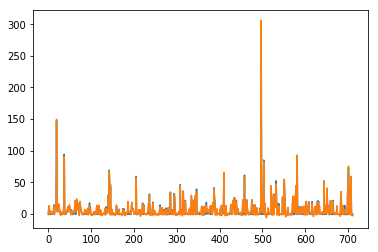

In [25]:
show_result (x_forward,y_forward,forward_model,scaler_forward,1)

In [32]:
yhat_back = back_model.predict(x_back)
yhat_back = scaler_back.inverse_transform(yhat_back)
yhat_back = np.maximum(yhat_back,0)
####
yhat_forward = forward_model.predict(x_forward)
yhat_forward = scaler_forward.inverse_transform(yhat_forward)
yhat_forward = np.maximum(yhat_forward,0)

y_b = scaler_back.inverse_transform(y_back)
y_f = scaler_forward.inverse_transform(y_forward)
i = 4
# plt.plot(range(y_forward[:,i].shape[0]),y_f[:,i],range(y_forward[:,i].shape[0]),yhat_forward[:,i])
# plt.figure()
# plt.plot(range(y_forward[:,i].shape[0]),y_b[:,i],range(y_forward[:,i].shape[0]),yhat_back[:,i])


y_final = np.array([])
y_final = np.append(yhat_back,yhat_forward[692:],axis=0)
# y_final.append(yhat_forward)
# y_final = np.array(y_final)
# y_final = y_final.reshape(-1,64)
y_final.shape
# y_final.shape
plt.plot(range(time_series[:,i].shape[0]),time_series[:,i],range(time_series[:,i].shape[0]),y_final[:,i])
# print(y_f[0])
# print(y_b[5])
to_submit_file(time_series,y_final)